In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, log_loss
from scipy.stats import mode
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import shap

In [8]:
def read_data(file_path = "/Users/philazar/Desktop/march-madness/data/data-2022/model-dev/training/all_features.csv"):
    df = pd.read_csv(file_path)
    df.drop(columns = ['TeamID_x', 'TeamID_y', 'year_trend_y', 'year_trend_x'], inplace=True)
    df['exp_points'] = (.4*df['hppg'] + .6*df['aoppg']) - (.4*df['appg'] + .6*df['hoppg'])
    return df 

In [68]:
def our_xgb_model(X_train,y_train,holdout_x, holdout_y):
    scores= []
    pars = {
        'colsample_bytree': 0.8,                 
        'learning_rate': 0.08,
        'max_depth': 10,
        'subsample': 1,
        'min_child_weight':3,
        'gamma':0.25,
        'n_estimators': 1000, 
        'objective':'binary:logistic'
        
    }
   
    model = xgb.XGBClassifier(objective = 'binary:logistic', 
                              eval_metric = 'logloss', 
                              n_estimators = 1000, 
                             learning_rate = .08, 
                             min_child_weight = .3 )
    model.fit(X_train, y_train, eval_metric = 'logloss')
    preds = model.predict_proba(holdout_x)
    print(log_loss(y_true = holdout_y, y_pred = preds))
    return model, preds 
    
    

In [73]:
all_data = read_data()
# fit it all to get some feature importance 
features = [c for c in all_data.columns if c not in ['Season', 'hTeamID', 'aTeamID', 'ID', 'Y']]
X_train = all_data.loc[all_data['Season'] < 2021, features]
Y_train = all_data.loc[all_data['Season'] < 2021, 'Y']
X_test = all_data.loc[all_data['Season'] == 2021, features]
Y_test = all_data.loc[all_data['Season'] == 2021, 'Y']
total_model, preds = our_xgb_model(X_train, Y_train, X_test, Y_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.9588171879215885


In [81]:
# see illinois preds
eval_df = all_data.loc[all_data['Season'] == 2021, ['Season', 'hTeamID', 'aTeamID', 'ID', 'Y']]
eval_df['prediciton'] = preds[:,1]
eval_df.loc[(eval_df['hTeamID'] == 1124)].head()


,Season,hTeamID,aTeamID,ID,Y,prediciton
1127,2021,1124,1216,2021_1124_1216,1.0,0.999772
1158,2021,1124,1458,2021_1124_1458,1.0,0.974620
1174,2021,1124,1437,2021_1124_1437,1.0,0.942850
1185,2021,1124,1222,2021_1124_1222,1.0,0.868442
1187,2021,1124,1211,2021_1124_1211,1.0,0.122860


In [80]:
all_data.loc[(all_data['hTeamID'] == 1124) | (all_data['aTeamID'] == 1228)].sort_values(["Season"], ascending = False)

,ID,Season,hTeamID,aTeamID,Y,htourn_seed,hAP,hKPK,hMAS,hMOR,...,n_yrs_at_school_ratio,coach_tot_yrs_diff,coach_tot_yrs_ratio,prev_wins_diff,prev_wins_ratio,coach_cum_wp_diff,coach_cum_wp_ratio,school_cum_wp_diff,school_cum_wp_ratio,exp_points
1160,2021_1228_1260,2021,1228,1260,0.0,1,2.000000,3.000000,2.000000,2.0,...,-6,-9,-9,0.0,0.0,-0.466667,-0.466667,-0.190000,-0.190000,-3.687003
1130,2021_1180_1228,2021,1180,1228,0.0,16,145.166667,161.000000,160.000000,131.0,...,1,4,4,0.0,0.0,-0.333333,-0.333333,-0.360000,-0.360000,-2.536479
700,2013_1228_1274,2013,1228,1274,0.0,7,39.500000,42.000000,36.000000,33.0,...,-1,-22,-22,0.0,0.0,0.000000,0.000000,0.118056,0.118056,-3.363636
674,2013_1160_1228,2013,1160,1228,0.0,10,48.000000,41.000000,45.000000,62.0,...,2,2,2,1.0,1.0,0.000000,0.000000,-0.162500,-0.162500,0.793750
561,2011_1228_1242,2011,1228,1242,0.0,9,32.000000,35.000000,42.000000,20.0,...,0,-5,-5,-1.0,-1.0,-0.088889,-0.088889,-0.164194,-0.164194,-4.430515
538,2011_1228_1424,2011,1228,1424,1.0,9,32.000000,35.000000,42.000000,20.0,...,1,-10,-10,0.0,0.0,0.045894,0.045894,-0.120497,-0.120497,-1.806250
401,2009_1228_1443,2009,1228,1443,0.0,5,23.250000,23.250000,23.250000,27.0,...,5,10,10,-2.0,-2.0,-0.019608,-0.019608,0.140278,0.140278,3.201369
287,2007_1228_1439,2007,1228,1439,0.0,12,34.500000,34.500000,34.500000,40.0,...,0,-8,-8,1.0,1.0,0.687500,0.687500,0.340909,0.340909,1.776281
200,2006_1102_1228,2006,1102,1228,0.0,13,52.400000,49.000000,52.400000,58.0,...,-2,-5,-5,-5.0,-5.0,-0.714286,-0.714286,-0.595238,-0.595238,-0.471889
232,2006_1228_1449,2006,1228,1449,0.0,4,13.000000,7.000000,10.714286,9.0,...,-1,-2,-2,3.0,3.0,0.314286,0.314286,0.195238,0.195238,1.829032


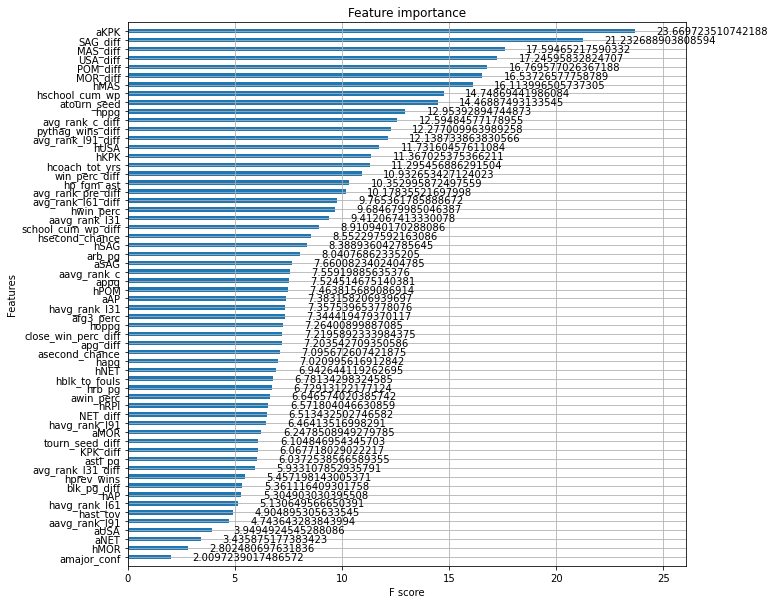

In [95]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(top_feat_model, max_num_features=60, height=0.5, ax=ax,importance_type='cover')
plt.show()

In [90]:
feature_dict = {'feature': [], 'importance': []}
for f, i in zip(features, total_model.feature_importances_):
    feature_dict['feature'].append(f)
    feature_dict['importance'].append(i)
feature_df = pd.DataFrame(feature_dict)
top_features = feature_df.sort_values(['importance'], ascending = False).head(60).feature
X_train = all_data.loc[all_data['Season'] < 2021, top_features]
Y_train = all_data.loc[all_data['Season'] < 2021, 'Y']
X_test = all_data.loc[all_data['Season'] == 2021, top_features]
Y_test = all_data.loc[all_data['Season'] == 2021, 'Y']
top_feat_model, new_preds = our_xgb_model(X_train, Y_train, X_test, Y_test)
eval_df['new_prediciton'] = new_preds[:,1]
eval_df.loc[(eval_df['hTeamID'] == 1124)].head()

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


1.0001439208916219


,Season,hTeamID,aTeamID,ID,Y,prediciton,new_prediciton
1127,2021,1124,1216,2021_1124_1216,1.0,0.999772,0.998198
1158,2021,1124,1458,2021_1124_1458,1.0,0.974620,0.992918
1174,2021,1124,1437,2021_1124_1437,1.0,0.942850,0.983592
1185,2021,1124,1222,2021_1124_1222,1.0,0.868442,0.670735
1187,2021,1124,1211,2021_1124_1211,1.0,0.122860,0.617062


In [98]:
eval_df.loc[(eval_df['aTeamID'] == 1417) | (eval_df['hTeamID'] == 1417) ].head(10)

,Season,hTeamID,aTeamID,ID,Y,prediciton,new_prediciton
1125,2021,1277,1417,2021_1277_1417,0.0,0.018356,0.040909
1155,2021,1140,1417,2021_1140_1417,0.0,0.014345,0.010336
1171,2021,1101,1417,2021_1101_1417,0.0,0.075593,0.330386
1179,2021,1104,1417,2021_1104_1417,0.0,0.771340,0.984015
1184,2021,1276,1417,2021_1276_1417,0.0,0.914335,0.994424
1186,2021,1211,1417,2021_1211_1417,1.0,0.980635,0.993463


In [97]:
top_feat_model.save_model('../top_feat_model.json')

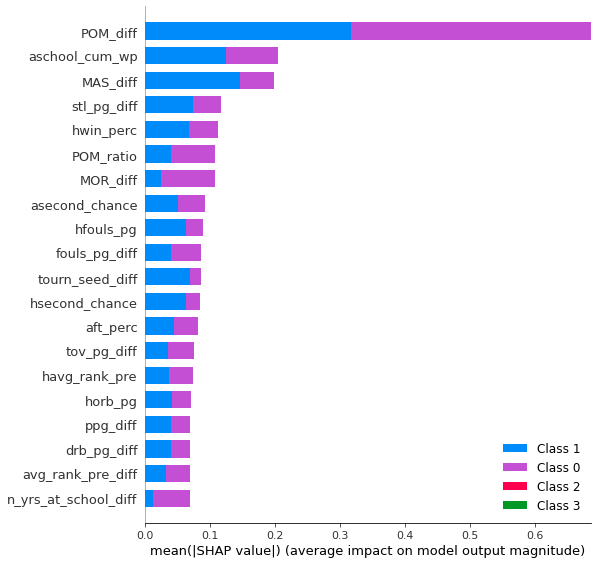

In [37]:
shap_values = shap.TreeExplainer(our_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [72]:
threshold = np.sort(total_model.feature_importances_)[40:]
for thresh in threshold:
    # select features using threshold
    selection = SelectFromModel(total_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = log_loss(y_test, predictions)
    print("Thresh=%.3f, n=%d, cohen kappa score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy))

NameError: name 'y_train' is not defined

In [47]:
threshold = np.sort(model.feature_importances_)[40:]

In [49]:
model.feature_importances_

array([0.00600762, 0.        , 0.00407296, 0.00518746, 0.        ,
       0.04469274, 0.00831309, 0.00312543, 0.01219483, 0.01759549,
       0.00031186, 0.00349728, 0.00441649, 0.0028029 , 0.00573498,
       0.00860668, 0.        , 0.00404062, 0.00319677, 0.        ,
       0.        , 0.00306494, 0.00513691, 0.00360987, 0.00263846,
       0.00215249, 0.00318603, 0.00553276, 0.00520924, 0.00936714,
       0.01032986, 0.00565391, 0.00534884, 0.00529944, 0.00739983,
       0.00298039, 0.00174401, 0.00147793, 0.00542913, 0.00404969,
       0.00351505, 0.00141401, 0.00318813, 0.00546636, 0.        ,
       0.00366117, 0.00562785, 0.        , 0.00645603, 0.00948296,
       0.00163152, 0.01268133, 0.01018078, 0.0008122 , 0.00401012,
       0.01535979, 0.00783005, 0.01553295, 0.00190237, 0.00204714,
       0.        , 0.01123213, 0.00636704, 0.00408636, 0.00214791,
       0.00357734, 0.        , 0.00247606, 0.00309796, 0.00076744,
       0.00405522, 0.00253621, 0.00489567, 0.00707058, 0.00662

In [ ]:
xg